In [1]:
# Using:
# - Python 3.8.8
# - PyTorch 1.8.1

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Generative model

### Data import

In [2]:
def get_dataset():
    with open("data_corridor_6000.json", "r") as read_file:
        data = json.load(read_file)
        
        pos = np.array(list(map(lambda x: 
            x['position']['y'], data)))
        
                
        ranges = np.array(list(map(lambda x: x['laser_ranges'], data)))        
        ranges[ranges == np.inf] = 15  # replaces infinity values with 20
        
        # Ranges in all samples are prefixed and sufixed with 22 constant values (close to 0)
        trim_size = 22
        for i in range(0, trim_size):
            ranges = np.delete(ranges, 0, axis=1)
        for i in range(0, trim_size):
            ranges = np.delete(ranges, len(ranges[0]) - 1, axis=1)
        
    return pos, ranges

In [3]:
pos, ranges = get_dataset()

### Data visualization

In [4]:
ranges_len = len(ranges[0])
def range_angle(idx):
    return -10 + (idx * 200 / ranges_len)

def prettify_ranges(ranges):
    ranges_plot = []
    for i, val in enumerate(ranges):
        x, y = (0, 0)

        # find the end point    
        endy = y + val * math.sin(math.radians(range_angle(i)))
        endx = val * math.cos(math.radians(range_angle(i)))

        ranges_plot.append([endx, endy])
    
    return np.array(ranges_plot)

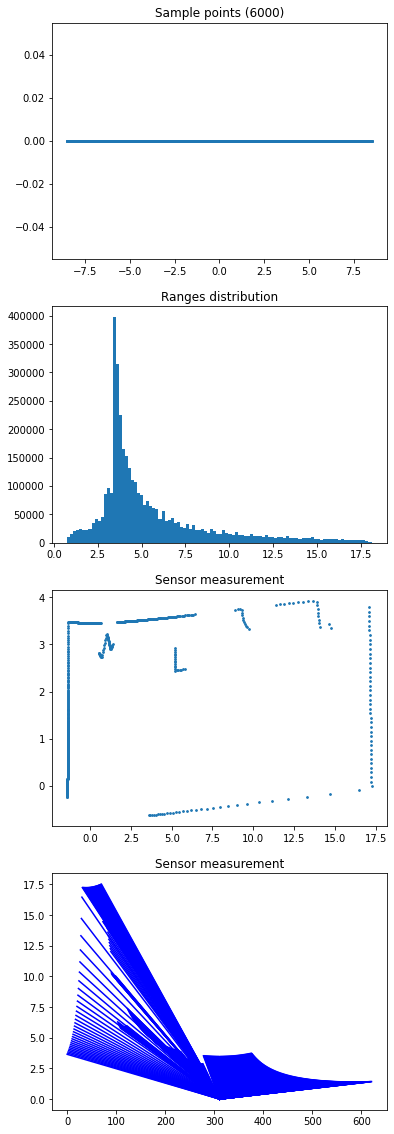

In [5]:
fig, axs = plt.subplots(4)
fig.set_figheight(20)

axs[0].set_title('Sample points ({length})'.format(length=len(pos)))
axs[0].scatter(pos, np.zeros(len(pos)), s=3);

all_ranges = np.concatenate(ranges).ravel()
axs[1].set_title('Ranges distribution')
axs[1].hist(all_ranges, bins=100)

ranges_plot = prettify_ranges(ranges[0])
axs[2].set_title('Sensor measurement')
axs[2].scatter(ranges_plot[:, 0], ranges_plot[:, 1], s=3);

axs[3].set_title('Sensor measurement')
for i in range(len(ranges[0])):
    axs[3].plot([len(ranges[0])/2, i], [0, ranges[0][i]], '-b')

### Data normalization

In [6]:
ranges_max = ranges.max()
ranges_min = ranges.min()

def normalize_ranges(ranges_matrix):
    ranges_matrix = (ranges_matrix - ranges_min) / (ranges_max - ranges_min)
    return ranges_matrix
    
def normalize_pos(positions):
    positions = (positions - positions.min()) / (positions.max() - positions.min())
    return positions

def unormalize_ranges(ranges):
    return ranges * (ranges_max - ranges_min) + ranges_min;

Train data points: 5000
Test data points: 1000
Length of ranges per data point: 622


(array([  7875.,  13257.,  16172.,  17476.,  19592.,  17732.,  19149.,
         19461.,  29346.,  35347.,  31799.,  37934.,  71717.,  79983.,
         71785., 331327., 262309., 187937., 137169., 128151., 109228.,
         92151.,  88821.,  72802.,  69535.,  55229.,  60556.,  53822.,
         51224.,  49044.,  35181.,  46501.,  32679.,  32824.,  36079.,
         28192.,  29988.,  22697.,  21855.,  26949.,  20220.,  25524.,
         18233.,  18608.,  20033.,  17497.,  14283.,  19813.,  16639.,
         13280.,  12841.,  18075.,  14763.,  12737.,  11263.,  15928.,
         10848.,  10560.,  10078.,   9468.,  11887.,   9651.,   9580.,
          9363.,   8705.,  10628.,   8278.,   8459.,   7200.,   7682.,
          7744.,   7534.,  10441.,   7535.,   5904.,   6908.,   5632.,
          6499.,   6143.,   6399.,   7691.,   5492.,   4457.,   4371.,
          5119.,   4895.,   4968.,   4921.,   4850.,   4524.,   4995.,
          4166.,   3977.,   3673.,   4317.,   3850.,   3805.,   3665.,
      

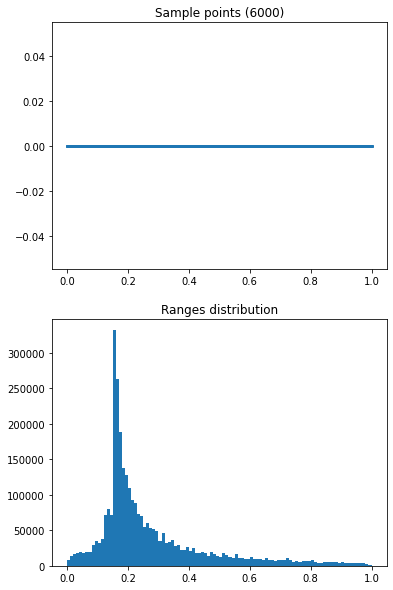

In [7]:
# Splitting dataset into test and train
dataset_size = len(pos)
train_data_percentage = 0.8334
train_upto_idx = int(dataset_size * train_data_percentage)

train_pos = pos[0 : train_upto_idx]
train_ranges = ranges[0 : train_upto_idx]
test_pos = pos[train_upto_idx : dataset_size]
test_ranges = ranges[train_upto_idx : dataset_size]


print('Train data points: {length}'.format(length=len(train_pos)))
print('Test data points: {length}'.format(length=len(test_pos)))
print('Length of ranges per data point: {length}'.format(length=len(ranges[0])))


# Normalizing data
train_pos = normalize_pos(train_pos)
train_ranges = normalize_ranges(train_ranges)
test_pos = normalize_pos(test_pos)
test_ranges = normalize_ranges(test_ranges)

# Visualizing normalized data
fig, axs = plt.subplots(2)
fig.set_figheight(10)

axs[0].set_title('Sample points ({length})'.format(length=len(pos)))
axs[0].scatter(train_pos, np.zeros(len(train_pos)), s=3);

axs[1].set_title('Ranges distribution')
axs[1].hist(np.concatenate(train_ranges).ravel(), bins=100)

### Transposed Convolutional Neural Network

In [8]:
class ConvTransposeNet(nn.Module):
    def __init__(self):
        super(ConvTransposeNet, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(1, 99),
            nn.ReLU(),
            nn.Linear(99, 198),
            nn.ReLU(),
            
            nn.ConvTranspose1d(in_channels=1, out_channels = 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=1, out_channels = 1, kernel_size=22, stride=3, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=1, out_channels = 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(),
        )
        
        
    def forward(self, x):     
        out = self.layers(x)
        
        return out

In [9]:
torch.set_default_tensor_type('torch.DoubleTensor')

# Hyperparameters
num_epochs = 15
batch_size = 500
learning_rate = 0.002

train_tensor_dataset = TensorDataset(torch.from_numpy(train_pos).double(), torch.from_numpy(train_ranges).double())
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)

test_tensor_dataset = TensorDataset(torch.from_numpy(test_pos).double(), torch.from_numpy(test_ranges).double())
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)

test_batch_pos, test_batch_ranges = next(iter(test_loader))
test_batch_pos.unsqueeze_(1)
test_batch_pos.unsqueeze_(1)
test_batch_ranges.unsqueeze_(1)

tensor([[[0.0278, 0.0277, 0.0277,  ..., 0.1777, 0.1719, 0.1663]],

        [[0.1663, 0.1719, 0.1777,  ..., 0.1777, 0.1719, 0.1663]],

        [[0.1663, 0.1719, 0.1777,  ..., 0.1777, 0.1719, 0.1663]],

        ...,

        [[0.1663, 0.1719, 0.1777,  ..., 0.1777, 0.1719, 0.1663]],

        [[0.1195, 0.1193, 0.1191,  ..., 0.1777, 0.1719, 0.1663]],

        [[0.1638, 0.1635, 0.1633,  ..., 0.1777, 0.1719, 0.1663]]])

### Model training

Final error: 0.03826656217513328


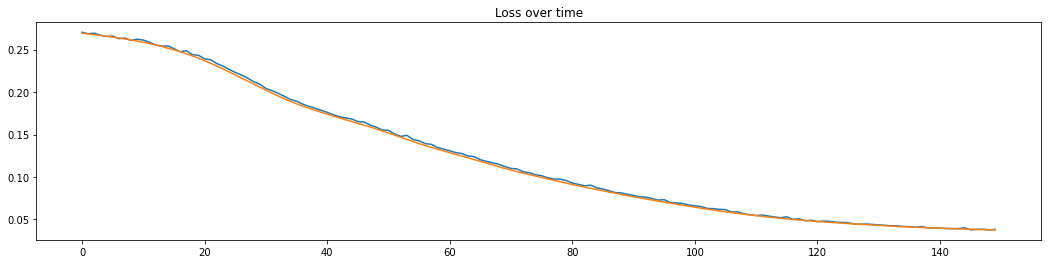

In [25]:
model = ConvTransposeNet()

# Loss and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    for i, (pos, ranges) in enumerate(train_loader):
        pos.unsqueeze_(1) # adds one extra dimension to make it (batch_size, 1, 1) for the ConvTranspose1d        
        pos.unsqueeze_(1)
        ranges.unsqueeze_(1)
        
        # Forward pass
        outputs = model(pos)
        
        # Loss computation
        loss = criterion(outputs, ranges)
        loss_list.append(loss.item())        
        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        # Test loss computation        
        test_outputs = model(test_batch_pos)
        test_loss = criterion(test_outputs, test_batch_ranges)
        test_loss_list.append(test_loss.item())


fig2, axs2 = plt.subplots()
fig2.set_figwidth(18)
axs2.set_title('Loss over time')
axs2.plot(np.arange(len(loss_list)), loss_list);
axs2.plot(np.arange(len(test_loss_list)), test_loss_list);

print('Final error: {x}'.format(x=loss_list[-1]))

### Model performance visualization

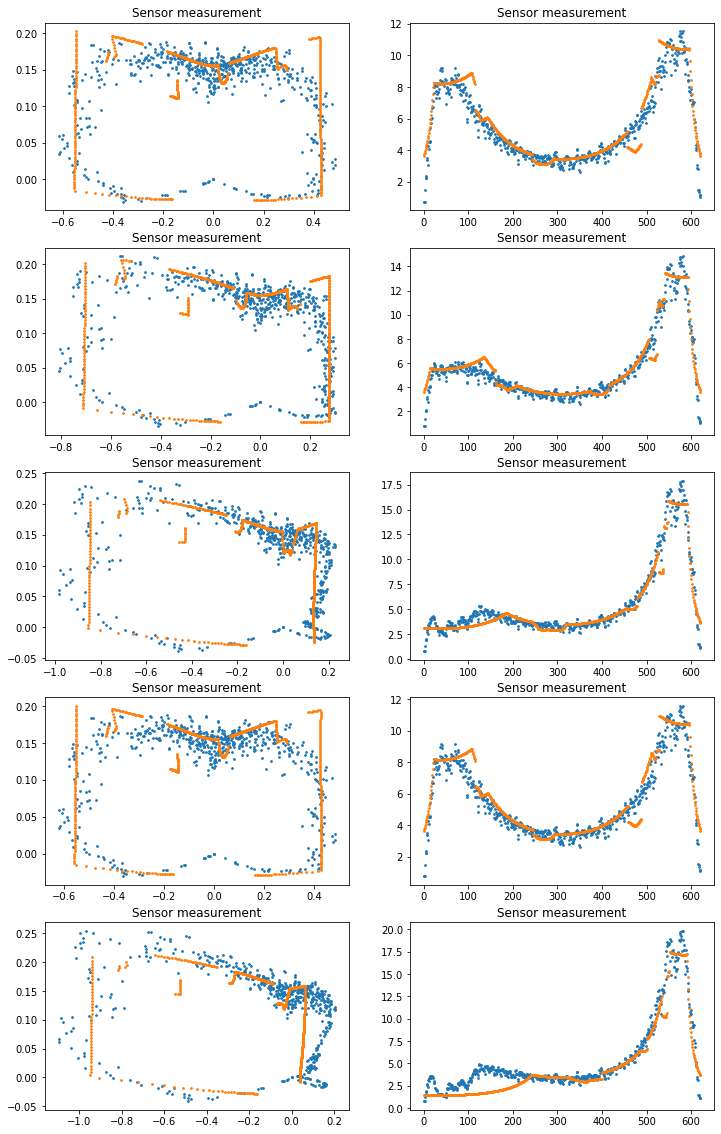

In [13]:
criterion = nn.L1Loss()
test_outputs = model(test_batch_pos)
test_loss = criterion(test_outputs, test_batch_ranges)

nr_plots = 5
fig3, axs3 = plt.subplots(nr_plots, 2)
fig3.set_figheight(nr_plots * 4)
fig3.set_figwidth(12)

for i in range(nr_plots):
    sample_idx = random.randint(0, len(test_outputs))
    single_output = test_outputs[sample_idx][0].detach().numpy()
    single_true_output = test_batch_ranges[sample_idx][0].detach().numpy()
    
    
    pred_ranges_prettified = prettify_ranges(single_output)
    true_ranges_prettified = prettify_ranges(single_true_output)
    axs3[i][0].set_title('Sensor measurement')
    axs3[i][0].scatter(pred_ranges_prettified[:, 0], pred_ranges_prettified[:, 1], s=3);
    axs3[i][0].scatter(true_ranges_prettified[:, 0], true_ranges_prettified[:, 1], s=3);
    
    axs3[i][1].set_title('Sensor measurement')
    axs3[i][1].scatter(np.arange(len(single_output)), unormalize_ranges(single_output), s=3);
    axs3[i][1].scatter(np.arange(len(single_true_output)), unormalize_ranges(single_true_output), s=3);
    

### Save model

In [29]:
torch.save(model.state_dict(), "model_corridor")

### Load model

In [11]:
model = ConvTransposeNet()
model.load_state_dict(torch.load("model_corridor"))
model.eval()

ConvTransposeNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=99, bias=True)
    (1): ReLU()
    (2): Linear(in_features=99, out_features=198, bias=True)
    (3): ReLU()
    (4): ConvTranspose1d(1, 1, kernel_size=(4,), stride=(1,), bias=False)
    (5): ReLU()
    (6): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
    (7): ReLU()
    (8): ConvTranspose1d(1, 1, kernel_size=(22,), stride=(3,), bias=False)
    (9): ReLU()
    (10): Conv1d(1, 1, kernel_size=(1,), stride=(1,), bias=False)
    (11): ReLU()
  )
)

# Predictive coding model

In [14]:
def fep(belief_x, real_ranges):
    input = Variable(belief_x, requires_grad=True)

    # Generative model prediction (from internal state to sensory space)
    pred_ranges = model(input)

    # Prediction error (Free Energy)
    pred_error = real_ranges - pred_ranges   # torch.Size([1, 1, 622])        
    
    # Precision vector
    sigma = torch.tensor([1] * 622)   # torch.Size([622]) 

    # 
    dF_dg = (1/sigma) * pred_error  # torch.Size([1, 1, 622])

    # Sets gradient to zero
    input.grad=torch.zeros(input.size())
    
    # Backpagates the error
    pred_ranges.backward(torch.ones(pred_ranges.shape)*dF_dg,retain_graph=True)

    # Returns gradient
    return input.grad


def run(belief_x, real_ranges, iterations):
    belief_x_hist = [belief_x.item()]
    for i in range(0, iterations):
        belief_x_dot = fep(belief_x, real_ranges)
        belief_x = torch.add(belief_x, belief_x_dot, alpha=0.003) # alpha = learning rate
        belief_x_hist.append(belief_x.item())
    
    return belief_x_hist

torch.Size([1, 622])
Real x: 0.3071260306242639
Initial belief of x: -16.0
Final belief of x: 0.3184171834684417


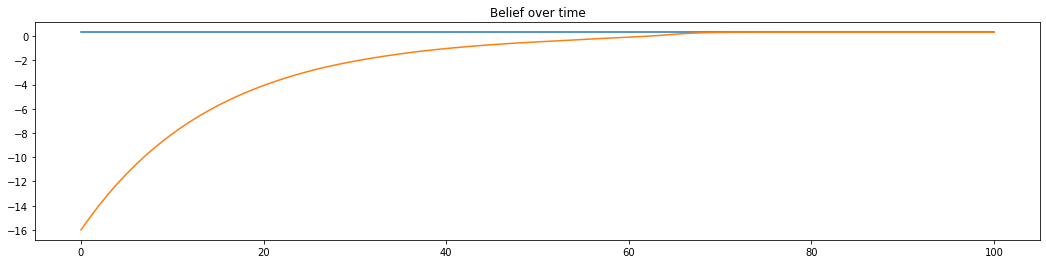

In [29]:
sample_idx = 356   # random sample from the test set
real_x = test_batch_pos[sample_idx]    # real position
real_ranges = test_batch_ranges[sample_idx]    # real measurement
belief_x = torch.tensor([[[-16.0]]])      # initial belief
iterations = 100

print(real_ranges.shape)

belief_x_hist = run(belief_x, real_ranges, iterations)

print('Real x: {x}'.format(x=real_x[0][0]))
print('Initial belief of x: {x}'.format(x=belief_x_hist[0]))
print('Final belief of x: {x}'.format(x=belief_x_hist[-1]))


fig4, axs4 = plt.subplots()
fig4.set_figwidth(18)
axs4.set_title('Belief over time')
axs4.plot(np.arange(len(belief_x_hist)), [real_x] * len(belief_x_hist));
axs4.plot(np.arange(len(belief_x_hist)), belief_x_hist);

In [38]:
def load_comparative():
    with open("inferred_poses.json", "r") as read_file:
        data = json.load(read_file)
        
        inferred = np.array(list(map(lambda x: 
            x['amcl']['y'], data)))
        
        true = np.array(list(map(lambda x: 
            x['true']['y'], data)))
        
        ranges = np.array(list(map(lambda x: x['laser'], data)))        
        ranges[ranges == np.inf] = 15  # replaces infinity values with 20
        
        # Ranges in all samples are prefixed and sufixed with 22 constant values (close to 0)
        trim_size = 22
        for i in range(0, trim_size):
            ranges = np.delete(ranges, 0, axis=1)
        for i in range(0, trim_size):
            ranges = np.delete(ranges, len(ranges[0]) - 1, axis=1)
        
    return inferred, true, ranges

stat_inferred, stat_true, stat_ranges = load_comparative()

stat_inferred = normalize_pos(stat_inferred)
stat_true = normalize_pos(stat_true)
stat_ranges = normalize_ranges(stat_ranges)

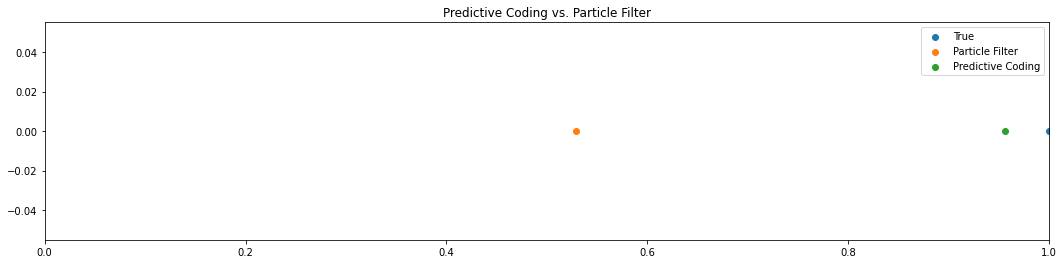

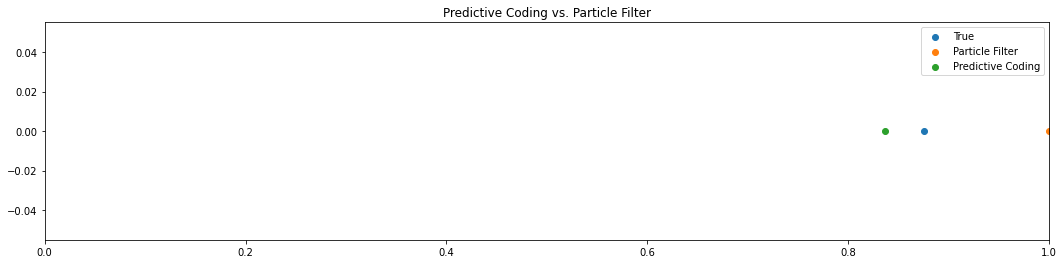

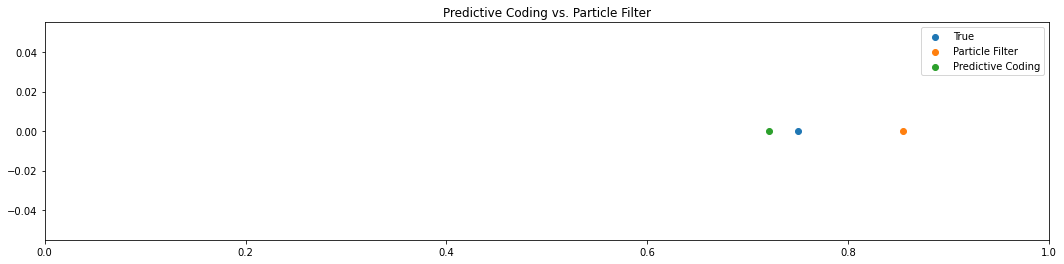

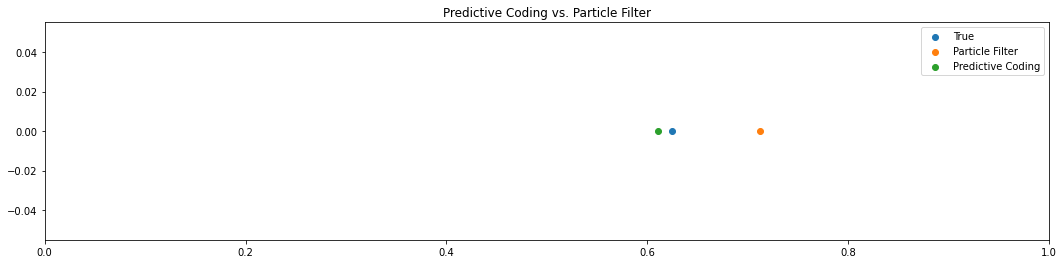

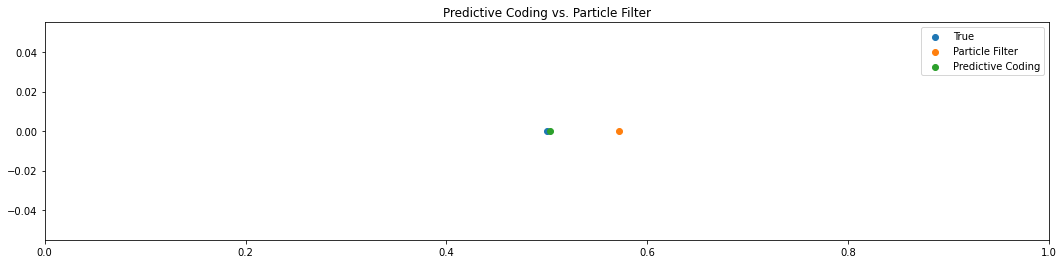

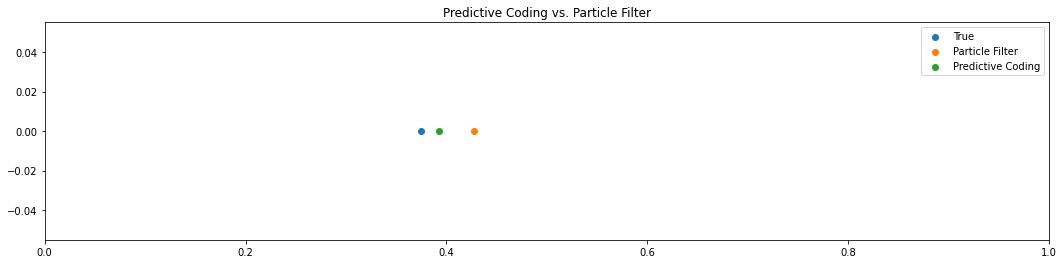

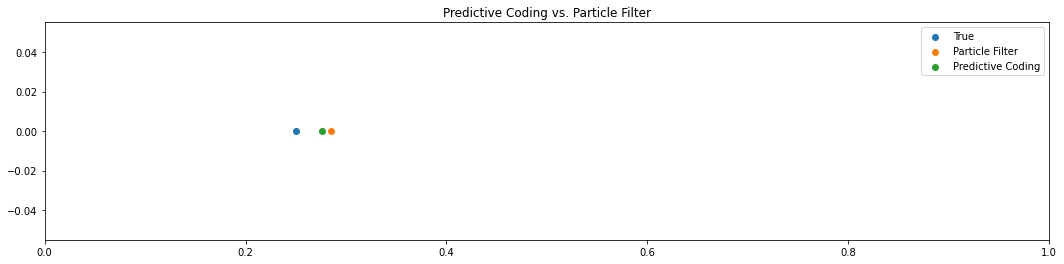

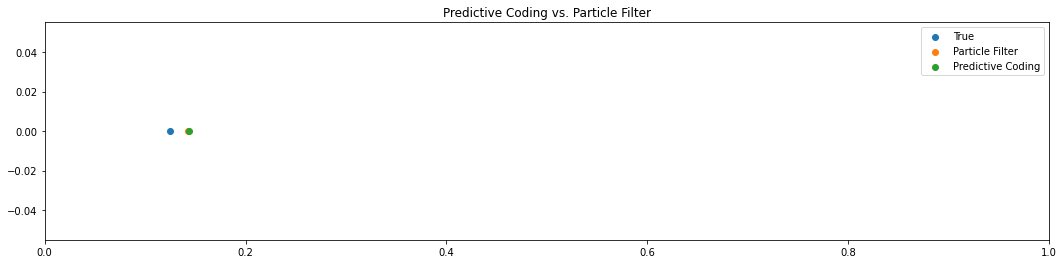

In [52]:
stat_model = []
for i in range(len(stat_true) - 1):
    model_pred = run(torch.tensor([[[0.0]]]), torch.tensor([stat_ranges[i]]), iterations)[-1]
    stat_model.append(model_pred)
    

for i in range(len(stat_true) - 1):
    fig2, axs2 = plt.subplots()
    fig2.set_figwidth(18)
    axs2.set_title('Predictive Coding vs. Particle Filter')
    axs2.scatter(stat_true[i], 0, label='True');
    axs2.scatter(stat_inferred[i], 0, label='Particle Filter');
    axs2.scatter(stat_model[i], 0, label='Predictive Coding');
    axs2.legend()
    plt.xlim([0, 1])